#### Import

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
import cv2 # OpenCV per il processamento delle immagini
from PIL import Image # Pillow per un'alternativa al caricamento immagini


#### Configurazione iniziale

In [ ]:
# --- Configurazione Iniziale ---
IMAGE_DIR = './augmented_dataset' # Cartella contenente le immagini
TARGET_SIZE = (128, 128 ) # Provare diverse risoluzioni (es. 32x32, 48x48, 64x64, 96x96)
CONVERT_TO_GRAYSCALE = False # Impostare a True se il colore non è discriminante
TEST_SET_SIZE = 0.15 # Percentuale del dataset da riservare al test set
VALIDATION_SET_SIZE = 0.15 # Rispetto al dataset rimanente dopo lo split del test set 
RANDOM_STATE = 42 # Per la riproducibilità

#### Caricamento e Analisi iniziale del dataset

In [ ]:
def load_images_and_labels(image_dir):
    """
    Carica immagini e etichette da una directory strutturata per classi.
    Ogni sottocartella in image_dir è considerata una classe.
    """
    images = []
    labels = []
    class_names = sorted(os.listdir(image_dir))
    label_map = {class_name: i for i, class_name in enumerate(class_names)}

    print(f"Trovate {len(class_names)} classi: {class_names}")

    for class_name in class_names:
        class_path = os.path.join(image_dir, class_name)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                try:
                    # Caricamento con OpenCV (puoi usare PIL se preferisci)
                    img = cv2.imread(image_path)
                    if img is not None:
                        images.append(img)
                        labels.append(label_map[class_name])
                    else:
                        print(f"Attenzione: Impossibile caricare l'immagine {image_path}")
                except Exception as e:
                    print(f"Errore durante il caricamento di {image_path}: {e}")

    print(f"Caricate {len(images)} immagini.")
    return np.array(images, dtype=object), np.array(labels), class_names, label_map

In [ ]:
def analyze_dataset(labels, class_names):
    """
    Analizza la distribuzione delle classi.
    """
    counts = Counter(labels)
    print("\n--- Analisi del Dataset ---")
    print("Distribuzione delle immagini per classe:")
    for i, class_name in enumerate(class_names):
        print(f"- Classe '{class_name}' (ID: {i}): {counts[i]} immagini")

    # Verifica sbilanciamento
    if len(set(counts.values())) > 1: # Se ci sono conteggi diversi
        print("Attenzione: Il dataset potrebbe essere sbilanciato.")
        # Qui potresti implementare o considerare tecniche di bilanciamento
        # come oversampling, undersampling, o l'uso di pesi per le classi
        # durante l'addestramento del modello. Per ora, procediamo.

In [ ]:
def display_sample_images(images, labels, class_names, num_samples_per_class=3):
    """
    Visualizza alcuni campioni per ogni classe.
    """
    print("\n--- Campioni di Immagini per Classe ---")
    unique_labels = np.unique(labels)
    fig, axes = plt.subplots(len(unique_labels), num_samples_per_class, figsize=(10, len(unique_labels) * 2))
    fig.suptitle("Campioni di Immagini per Classe", fontsize=16)

    for i, label in enumerate(unique_labels):
        class_images = [img for img, lbl in zip(images, labels) if lbl == label]
        if not class_images:
            print(f"Nessuna immagine trovata per la classe {class_names[label]}")
            continue

        for j in range(num_samples_per_class):
            if j < len(class_images):
                ax = axes[i, j] if len(unique_labels) > 1 else axes[j]
                # OpenCV carica in BGR, Matplotlib si aspetta RGB
                img = np.array(class_images[j], dtype=np.uint8) # Forzo il tipo di dato a uint8
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ax.imshow(img_rgb)
                ax.set_title(f"Classe: {class_names[label]}")
                ax.axis('off')
            else:
                # Nascondi subplot vuoti se ci sono meno campioni della num_samples_per_class
                if len(unique_labels) > 1:
                    axes[i,j].axis('off')
                else:
                    axes[j].axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Aggiusta il layout per far spazio al titolo
    plt.show()

#### Suddivisione del dataset

In [ ]:
def split_dataset(images, labels):
    """
    Suddivide il dataset in set di addestramento, validazione e test in modo stratificato.
    """
    print("\n--- Suddivisione del Dataset ---")
    # Prima suddivisione: training + validation vs test
    train_val_images, test_images, train_val_labels, test_labels = train_test_split(
        images, labels,
        test_size=TEST_SET_SIZE,
        stratify=labels, # Mantiene le proporzioni delle classi
        random_state=RANDOM_STATE
    )

    # Seconda suddivisione: training vs validation
    # Calcola la dimensione del set di validazione rispetto al set train_val combinato
    relative_validation_size = VALIDATION_SET_SIZE / (1 - TEST_SET_SIZE)
    train_images, val_images, train_labels, val_labels = train_test_split(
        train_val_images, train_val_labels,
        test_size=relative_validation_size,
        stratify=train_val_labels, # Mantiene le proporzioni delle classi
        random_state=RANDOM_STATE
    )

    print(f"Dimensioni dei set:")
    print(f"- Training:   {len(train_images)} immagini, {len(np.unique(train_labels))} classi")
    print(f"- Validation: {len(val_images)} immagini, {len(np.unique(val_labels))} classi")
    print(f"- Test:       {len(test_images)} immagini, {len(np.unique(test_labels))} classi")

    print("\nDistribuzione classi nel Training set:")
    print(Counter(train_labels))
    print("\nDistribuzione classi nel Validation set:")
    print(Counter(val_labels))
    print("\nDistribuzione classi nel Test set:")
    print(Counter(test_labels))

    return train_images, train_labels, val_images, val_labels, test_images, test_labels

#### Preprocessing delle immagini

In [ ]:
def preprocess_image(image, target_size, convert_to_grayscale, training_mean=None, training_std=None):
    """
    Esegue il preprocessing su una singola immagine:
    - Ridimensionamento
    - Conversione in scala di grigi (opzionale)
    - Normalizzazione
    """
    img = np.array(image, dtype=np.uint8)
    # Ridimensionamento
    processed_image = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

    # Conversione in scala di grigi (opzionale)
    if convert_to_grayscale:
        if len(processed_image.shape) == 3 and processed_image.shape[2] == 3: # Se è a colori
            processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2GRAY)
        # Aggiungi una dimensione per il canale se è in scala di grigi e il modello se lo aspetta
        # (es. per CNN che si aspettano (altezza, larghezza, canali))
        if len(processed_image.shape) == 2:
             processed_image = np.expand_dims(processed_image, axis=-1)


    # Normalizzazione
    processed_image = processed_image.astype(np.float32)
    if training_mean is not None and training_std is not None:
        # Standardizzazione (Z-score normalization)
        processed_image = (processed_image - training_mean) / training_std
    else:
        # Scala i pixel a [0, 1]
        processed_image /= 255.0

    return processed_image

In [ ]:
def preprocess_dataset(images_list, target_size, convert_to_grayscale, fit_on_training=False, training_mean=None, training_std=None):
    """
    Applica il preprocessing a una lista di immagini.
    Se fit_on_training è True, calcola media e deviazione standard (per la standardizzazione)
    sul set fornito (tipicamente il training set) e li restituisce.
    Altrimenti, usa training_mean e training_std forniti.
    """
    processed_images = []

    if fit_on_training:
        # Calcola media e deviazione standard SUL TRAINING SET
        # Prima ridimensiona e converti in scala di grigi se necessario
        temp_images_for_stats = []
        for img in images_list:
            img_uint8 = np.array(img, dtype=np.uint8)
            resized_img = cv2.resize(img_uint8, target_size, interpolation=cv2.INTER_AREA)
            if convert_to_grayscale:
                if len(resized_img.shape) == 3 and resized_img.shape[2] == 3:
                    resized_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
                if len(resized_img.shape) == 2:
                    resized_img = np.expand_dims(resized_img, axis=-1)
            temp_images_for_stats.append(resized_img.astype(np.float32) / 255.0) # Normalizza a [0,1] prima di calcolare media/std

        stacked_images = np.stack(temp_images_for_stats)
        training_mean = np.mean(stacked_images, axis=(0, 1, 2)) # Media per canale se a colori, o globale se grigio
        training_std = np.std(stacked_images, axis=(0, 1, 2))
        print(f"\nCalcolati dal training set:")
        print(f"  Media per la standardizzazione: {training_mean}")
        print(f"  Deviazione standard per la standardizzazione: {training_std}")

    for img in images_list:
        processed_images.append(preprocess_image(img, target_size, convert_to_grayscale, training_mean, training_std))

    if fit_on_training:
        return np.array(processed_images), training_mean, training_std
    else:
        return np.array(processed_images)

#### Esecuzione del preprocessing

Trovate 2 classi: ['Mosquito', 'Not_Mosquito']
Caricate 26694 immagini.

--- Analisi del Dataset ---
Distribuzione delle immagini per classe:
- Classe 'Mosquito' (ID: 0): 4140 immagini
- Classe 'Not_Mosquito' (ID: 1): 22554 immagini
Attenzione: Il dataset potrebbe essere sbilanciato.

--- Campioni di Immagini per Classe ---


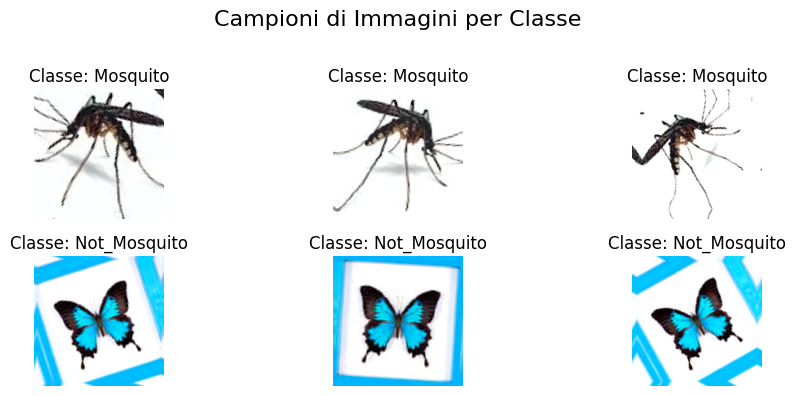


--- Suddivisione del Dataset ---
Dimensioni dei set:
- Training:   18685 immagini, 2 classi
- Validation: 4004 immagini, 2 classi
- Test:       4005 immagini, 2 classi

Distribuzione classi nel Training set:
Counter({np.int64(1): 15787, np.int64(0): 2898})

Distribuzione classi nel Validation set:
Counter({np.int64(1): 3383, np.int64(0): 621})

Distribuzione classi nel Test set:
Counter({np.int64(1): 3384, np.int64(0): 621})

--- Preprocessing delle Immagini (Target Size: (128, 128)) ---
Conversione in scala di grigi: No
Utilizzo della standardizzazione (Z-score).

Calcolati dal training set:
  Media per la standardizzazione: [0.05480332 0.05480332 0.05480332]
  Deviazione standard per la standardizzazione: [0.23410109 0.23410109 0.23410109]

Forma dei dati preprocessati:
- X_train: (18685, 128, 128, 3), y_train: (18685,)
- X_val:   (4004, 128, 128, 3), y_val: (4004,)
- X_test:  (4005, 128, 128, 3), y_test: (4005,)


In [ ]:
images, labels, class_names, label_map = load_images_and_labels(IMAGE_DIR)

if len(images) == 0:
    print(f"Nessuna immagine caricata. Controlla il percorso '{IMAGE_DIR}' e la struttura delle cartelle.")
else:
    analyze_dataset(labels, class_names)
    display_sample_images(images, labels, class_names, num_samples_per_class=3)

    # 2. Suddivisione del Dataset
    X_train_orig, y_train, X_val_orig, y_val, X_test_orig, y_test = split_dataset(images, labels)

    # 3. Preprocessing delle Immagini
    print(f"\n--- Preprocessing delle Immagini (Target Size: {TARGET_SIZE}) ---")
    print(f"Conversione in scala di grigi: {'Sì' if CONVERT_TO_GRAYSCALE else 'No'}")

    # Scegli se standardizzare o normalizzare a [0,1]
    # Per standardizzare, imposta use_standardization = True
    # Per normalizzare a [0,1], imposta use_standardization = False
    use_standardization = True # CAMBIA QUESTO PER TESTARE

    if use_standardization:
        print("Utilizzo della standardizzazione (Z-score).")
        X_train, train_mean, train_std = preprocess_dataset(
            X_train_orig, TARGET_SIZE, CONVERT_TO_GRAYSCALE, fit_on_training=True
        )
        X_val = preprocess_dataset(
            X_val_orig, TARGET_SIZE, CONVERT_TO_GRAYSCALE, training_mean=train_mean, training_std=train_std
        )
        X_test = preprocess_dataset(
            X_test_orig, TARGET_SIZE, CONVERT_TO_GRAYSCALE, training_mean=train_mean, training_std=train_std
        )
    else:
        print("Utilizzo della normalizzazione a [0,1].")
        X_train, _, _ = preprocess_dataset( # Ignora mean e std restituiti
            X_train_orig, TARGET_SIZE, CONVERT_TO_GRAYSCALE, fit_on_training=False # fit_on_training=False implica normalizzazione [0,1]
        )
        X_val = preprocess_dataset(
            X_val_orig, TARGET_SIZE, CONVERT_TO_GRAYSCALE, fit_on_training=False
        )
        X_test = preprocess_dataset(
            X_test_orig, TARGET_SIZE, CONVERT_TO_GRAYSCALE, fit_on_training=False
        )


    print(f"\nForma dei dati preprocessati:")
    print(f"- X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"- X_val:   {X_val.shape}, y_val: {y_val.shape}")
    print(f"- X_test:  {X_test.shape}, y_test: {y_test.shape}")


Valori min/max di un campione X_train dopo il preprocessing:
  Min: -0.2341010868549347, Max: 1089.0389404296875
  Media: 579.67578125, Deviazione Std: 372.0256042480469
  Tipo di dati: float32


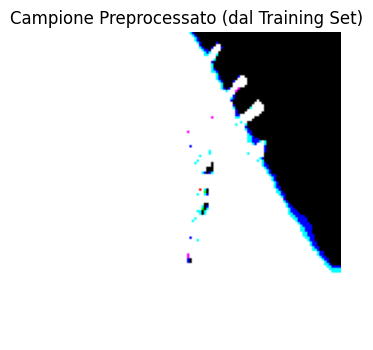


Preprocessing completato.


In [ ]:
# Verifica i valori dei pixel dopo il preprocessing (dovrebbero essere normalizzati)
print(f"\nValori min/max di un campione X_train dopo il preprocessing:")
if len(X_train) > 0:
    sample_processed_image = X_train[0]
    print(f"  Min: {sample_processed_image.min()}, Max: {sample_processed_image.max()}")
    print(f"  Media: {sample_processed_image.mean()}, Deviazione Std: {sample_processed_image.std()}")
    print(f"  Tipo di dati: {sample_processed_image.dtype}")

    # Visualizza un campione preprocessato
    plt.figure(figsize=(4,4))
    plt.title("Campione Preprocessato (dal Training Set)")
    # Se è in scala di grigi e ha un canale, rimuovilo per imshow
    if sample_processed_image.shape[-1] == 1:
        plt.imshow(sample_processed_image.squeeze(), cmap='gray')
    else:
        # Se hai usato la standardizzazione, i valori potrebbero non essere più in [0,1]
        # quindi potresti aver bisogno di clipparli o scalarli per una visualizzazione corretta.
        # Per semplicità, se standardizzato, visualizziamo senza clipping,
        # ma tieni presente che i colori potrebbero apparire strani.
        img_to_show = sample_processed_image
        if use_standardization: # Riporta approssimativamente a [0,1] per visualizzazione
            img_to_show = (sample_processed_image * train_std) + train_mean
            img_to_show = np.clip(img_to_show, 0, 1) # Clipa a [0,1] per evitare warning imshow

        plt.imshow(img_to_show)
    plt.axis('off')
    plt.show()

print("\nPreprocessing completato.")
# Ora X_train, y_train, X_val, y_val, X_test, y_test sono pronti
# per essere usati per addestrare un modello di classificazione.

### Transfer Learning

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms # Rimosso datasets perché non usiamo ImageFolder
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import numpy as np
from PIL import Image # Necessario per convertire array NumPy in immagini PIL se le transform lo richiedono

In [ ]:
print(f"PyTorch Version: {torch.__version__}")

NUM_CLASSES = 2 # Mosquito vs Not_Mosquito
BATCH_SIZE = 32 # Puoi ridurla se hai poca memoria GPU (es. 16 o 8)
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
MODEL_NAMES = ['ResNet18', 'ResNet50', 'MobileNetV2']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilizzo del dispositivo: {device}")

PyTorch Version: 2.7.0+cpu
Utilizzo del dispositivo: cpu


Estendo la classe Dataset di PyTorch e preparo i dati

In [ ]:
class CustomTensorDataset(Dataset):
    """Dataset personalizzata per dati e etichette in memoria (NumPy/Tensor)."""
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = torch.from_numpy(labels).long() if isinstance(labels, np.ndarray) else torch.tensor(labels).long()
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_data = self.data[idx]
        label = self.labels[idx]

        # Se i dati sono array NumPy, convertili in Immagini PIL,
        # perché molte trasformazioni di torchvision si aspettano PIL.
        if isinstance(sample_data, np.ndarray):
            # Assumendo che l'array NumPy sia HxWxC (Altezza, Larghezza, Canali)
            if sample_data.ndim == 2: # Immagine in scala di grigi
                sample_data = Image.fromarray(sample_data, mode='L')
            elif sample_data.shape[2] == 1: # Scala di grigi con un canale esplicito
                 sample_data = Image.fromarray(sample_data.squeeze(), mode='L')
            else: # RGB
                sample_data = Image.fromarray(sample_data)


        if self.transform:
            sample_data = self.transform(sample_data)
        
        return sample_data, label

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  # Resize per i mdeli per sicurezza
        transforms.RandomHorizontalFlip(),  # Ulteriore data augmentation
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalizzazione con stats ImageNet
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)), # Resize per i modelli per sicurezza
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalizzazione con stats ImageNet
    ]),
}


In [ ]:
# Crea le istanze Dataset personalizzate
try:
    train_dataset = CustomTensorDataset(X_train, y_train, transform=data_transforms['train'])
    val_dataset = CustomTensorDataset(X_val, y_val, transform=data_transforms['val'])
except NameError:
    print("ERRORE: Le variabili X_train, y_train, X_val, y_val non sono definite.")
    print("Assicurati diaver eseguito tutti i precedenti blocchi di questo notebook")
    exit()

In [ ]:
# Creazione dei DataLoader
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2), # num_workers>0 può dare problemi su Windows o in certi notebook
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

print(f"Dimensioni del dataset di Training: {dataset_sizes['train']}")
print(f"Dimensioni del dataset di Validazione: {dataset_sizes['val']}")

Dimensioni del dataset di Training: 18685
Dimensioni del dataset di Validazione: 4004


#### Definizione dei modelli

In [ ]:
def get_model(model_name_str, num_classes_val, pretrained=True):
    model_ft = None
    if model_name_str == 'ResNet18':
        model_ft = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
    elif model_name_str == 'ResNet50':
        model_ft = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None)
    elif model_name_str == 'MobileNetV2':
        model_ft = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1 if pretrained else None)
    else:
        print("Nome modello non valido")
        return None

    for param in model_ft.parameters():
        param.requires_grad = False

    if model_name_str.startswith('ResNet'):
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes_val)
    elif model_name_str == 'MobileNetV2':
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes_val)
    
    model_ft = model_ft.to(device)
    return model_ft

#### Funzione di Addestramento

In [ ]:
def train_model_instance(model, criterion, optimizer, num_epochs=NUM_EPOCHS):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoca {epoch+1}/{num_epochs}')
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]: # Qui inputs sono già tensori trasformati
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print(f'Addestramento completato in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Migliore Acc Valutazione: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model, history, best_acc.item()


### Training dei modelli

In [ ]:
all_histories = {}
final_accuracies = {}

for model_name_str in MODEL_NAMES:
    print(f"\n--- Addestramento del modello: {model_name_str} ---")
    model_ft = get_model(model_name_str, NUM_CLASSES)
    if model_ft is None: continue
    criterion = nn.CrossEntropyLoss()
    params_to_update = filter(lambda p: p.requires_grad, model_ft.parameters())
    optimizer_ft = optim.Adam(params_to_update, lr=LEARNING_RATE)
    trained_model, history, best_val_acc = train_model_instance(model_ft, criterion, optimizer_ft, num_epochs=NUM_EPOCHS)
    all_histories[model_name_str] = history
    final_accuracies[model_name_str] = best_val_acc

NameError: name 'MODEL_NAMES' is not defined

In [ ]:

# --- 6. Valutazione e Grafici di Confronto (identica) ---
print("\n--- Risultati Finali ---")
for model_name_val, acc in final_accuracies.items():
    print(f"Accuratezza finale di validazione per {model_name_val}: {acc:.4f}")

epochs_range = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
for model_name_plot, history_plot in all_histories.items():
    plt.plot(epochs_range, history_plot['train_loss'], label=f'{model_name_plot} Train Loss')
    plt.plot(epochs_range, history_plot['val_loss'], linestyle='--', label=f'{model_name_plot} Val Loss')
plt.title('Confronto Loss di Addestramento e Validazione')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
for model_name_plot, history_plot in all_histories.items():
    plt.plot(epochs_range, history_plot['train_acc'], label=f'{model_name_plot} Train Accuracy')
    plt.plot(epochs_range, history_plot['val_acc'], linestyle='--', label=f'{model_name_plot} Val Accuracy')
plt.title('Confronto Accuratezza di Addestramento e Validazione')
plt.xlabel('Epoche')
plt.ylabel('Accuratezza')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nCompletato!")